In [1]:
!pip install tensorflow==1.14

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt

np.random.seed(42)
tf.set_random_seed(42)

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [3]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


In [4]:
input_size = 28 * 28
num_classes = 10

In [5]:
params = {
    'encoder_layers': [128],                
    'decoder_layers': [128],                
    'classification_layers': [128],   # for conditions
    'activation': tf.nn.sigmoid,            
    'decoder_std': 0.5,                     # std for P(x|z) 
    'z_dim': 10,                            # latent space dimension
    'classification_weight': 10.0,    # for conditions
    'epochs': 25,
    'batch_size': 100,
    'learning_rate': 0.01
}

In [6]:
def encoder(x, layers):
    for layer in layers:
        x = tf.layers.dense(x, layer, activation=params['activation'])
    mu = tf.layers.dense(x, params['z_dim'])
    var = 1e-5 + tf.exp(tf.layers.dense(x, params['z_dim']))
    return mu, var


def decoder(z, layers):
    for layer in layers:
        z = tf.layers.dense(z, layer, activation=params['activation'])
    mu = tf.layers.dense(z, input_size)
    return tf.nn.sigmoid(mu)


def classifier(x, layers):
    for layer in layers:
        x = tf.layers.dense(x, layer, activation=params['activation'])
    logits = tf.layers.dense(x, num_classes)
    return logits

In [7]:
images = tf.placeholder(tf.float32, [None, input_size])
cloths = tf.placeholder(tf.int32, [None])

# encode the image into latent space
encoder_mu, encoder_var = encoder(images, params['encoder_layers'])

# sample the vector from latent space, using
# reparametrization
eps = tf.random_normal(shape=[tf.shape(images)[0], params['z_dim']], mean=0.0, stddev=1.0)
z = encoder_mu + tf.sqrt(encoder_var) * eps

# classify the cloths
digit_logits = classifier(images, params['classification_layers'])
digit_prob = tf.nn.softmax(digit_logits)

# decode latent vector using cloths classification condition into the image
decoded_images = decoder(tf.concat([z, digit_prob], axis=1), params['decoder_layers'])

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [8]:
# loss for reconstructed image
loss_reconstruction = -tf.reduce_sum(
    tf.contrib.distributions.Normal(
        decoded_images,
        params['decoder_std']
    ).log_prob(images),
    axis=1
)

# loss for the current hidden space distribution parameters
loss_prior = -0.5 * tf.reduce_sum(
    1 + tf.log(encoder_var) - encoder_mu ** 2 - encoder_var,
    axis=1
)

# autoencoder loss
loss_auto_encode = tf.reduce_mean(
    loss_reconstruction + loss_prior,
    axis=0
)

# loss for digit_classification
loss_classifier = params['classification_weight'] * tf.reduce_mean(
    tf.nn.sparse_softmax_cross_entropy_with_logits(labels=cloths, logits=digit_logits),
    axis=0
)

# final loss
loss = loss_auto_encode + loss_classifier

train_op = tf.train.AdamOptimizer(params['learning_rate']).minimize(loss)

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [9]:
# Training

samples = []
losses_auto_encode = []
losses_classifier = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(params['epochs']):
        print("Epoch # - ",epoch)
        for i in range(X_train.shape[0] // params['batch_size']):
            batch_images = X_train[i * params['batch_size']:(i + 1) * params['batch_size']] \
                .reshape(params['batch_size'], input_size)
            batch_cloths = y_train[i * params['batch_size']:(i + 1) * params['batch_size']] \
                .reshape(params['batch_size'], )
            sess.run(train_op, feed_dict={images: batch_images, cloths: batch_cloths})
        
        train_loss_auto_encode, train_loss_classifier = sess.run(
            [loss_auto_encode, loss_classifier],
            {images: np.reshape(X_train, (X_train.shape[0], input_size)), 
             cloths: np.reshape(y_train, (y_train.shape[0], ))})
        
        losses_auto_encode.append(train_loss_auto_encode)
        losses_classifier.append(train_loss_classifier)
        
        sample_z = np.tile(np.random.randn(1, params['z_dim']), reps=[num_classes, 1])
        gen_samples = sess.run(decoded_images,
                               feed_dict={z: sample_z, digit_prob: np.eye(num_classes)})
        samples.append(gen_samples)

print("\nTraining completed!")


Epoch # -  0
Epoch # -  1
Epoch # -  2
Epoch # -  3
Epoch # -  4
Epoch # -  5
Epoch # -  6
Epoch # -  7
Epoch # -  8
Epoch # -  9
Epoch # -  10
Epoch # -  11
Epoch # -  12
Epoch # -  13
Epoch # -  14
Epoch # -  15
Epoch # -  16
Epoch # -  17
Epoch # -  18
Epoch # -  19
Epoch # -  20
Epoch # -  21
Epoch # -  22
Epoch # -  23
Epoch # -  24

Training completed!


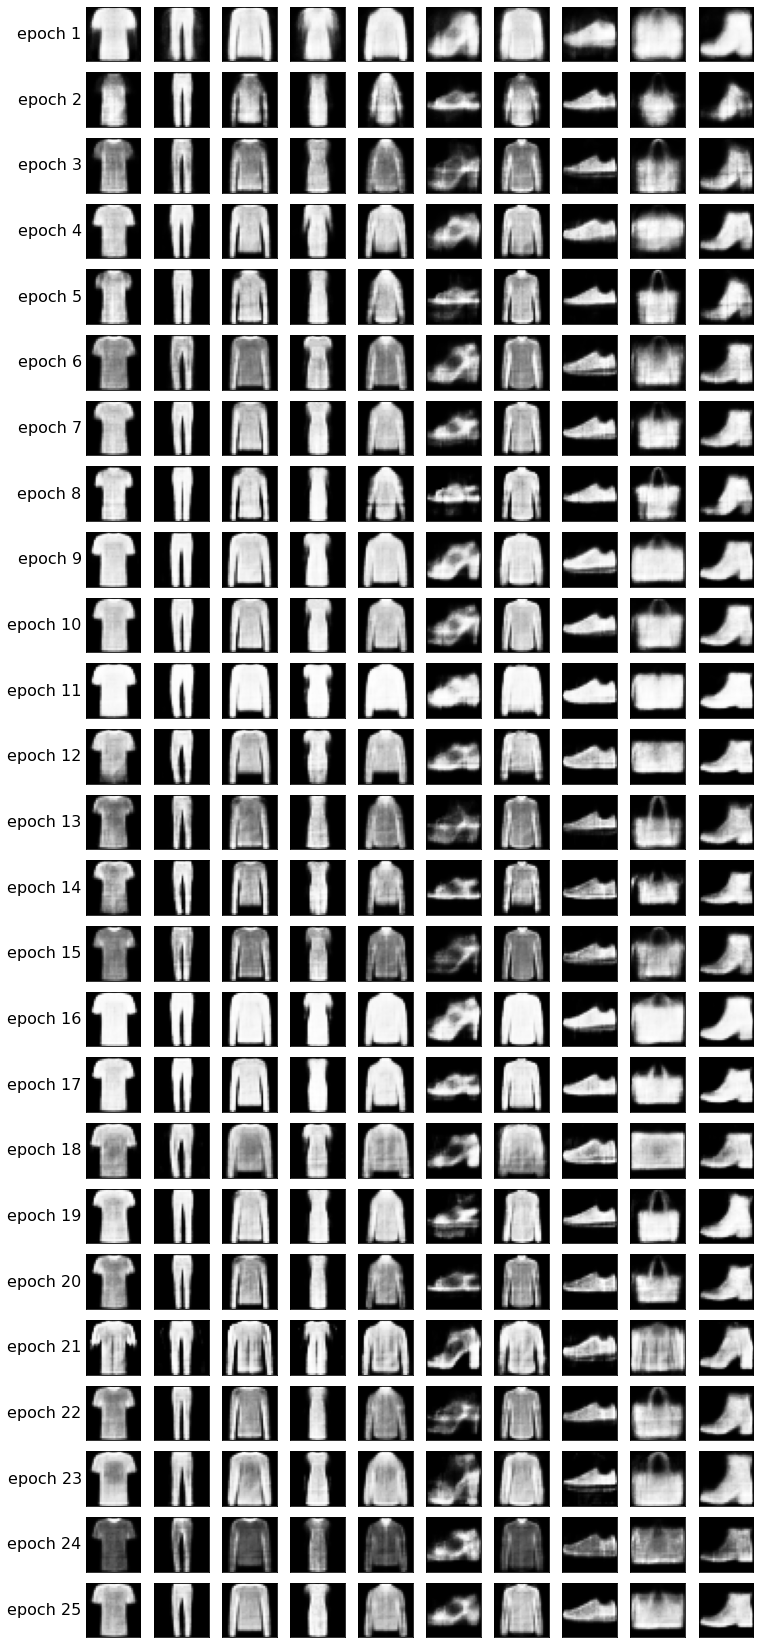

In [13]:
def plot_samples(samples):
    IMAGE_WIDTH = 1.2
    plt.figure(figsize=(IMAGE_WIDTH * num_classes, len(samples) * IMAGE_WIDTH))
    for epoch, images in enumerate(samples):
        for cloth, image in enumerate(images):
            plt.subplot(len(samples), num_classes, epoch * num_classes + cloth + 1)
            plt.imshow(image.reshape((28, 28)), cmap='Greys_r')
            plt.gca().xaxis.set_visible(False)
            if cloth == 0:
                plt.gca().yaxis.set_ticks([])
                plt.ylabel('epoch {}'.format(epoch + 1),
                           verticalalignment='center',
                           horizontalalignment='right',
                           rotation=0,
                           fontsize=16)
            else:
                plt.gca().yaxis.set_visible(False)
                
                
plot_samples(samples)

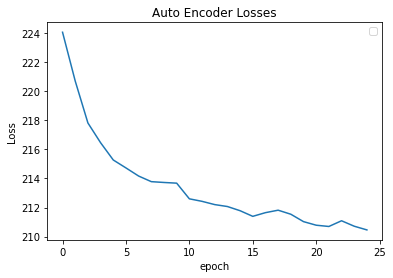

In [11]:
plt.plot(losses_auto_encode)
plt.title('Auto Encoder Losses')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

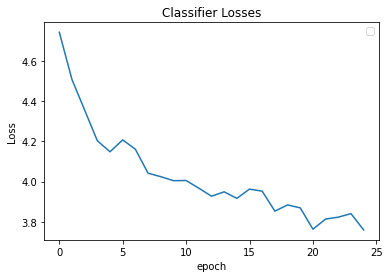

In [12]:
plt.plot(losses_classifier)
plt.title('Classifier Losses')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

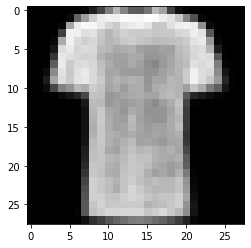

In [33]:
plt.imshow(samples[24][0].reshape((28, 28)), cmap='Greys_r')

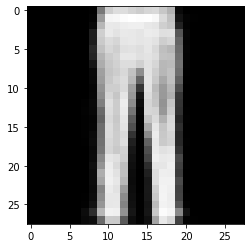

In [35]:
plt.imshow(samples[22][1].reshape((28, 28)), cmap='Greys_r')

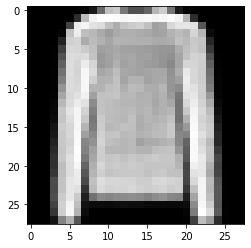

In [43]:
plt.imshow(samples[24][2].reshape((28, 28)), cmap='Greys_r')

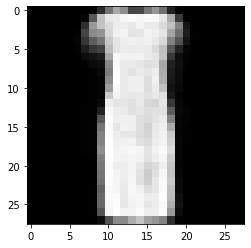

In [46]:
plt.imshow(samples[24][3].reshape((28, 28)), cmap='Greys_r')

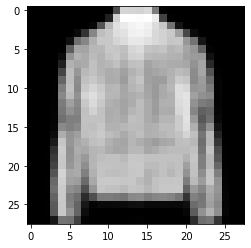

In [58]:
plt.imshow(samples[24][4].reshape((28, 28)), cmap='Greys_r')

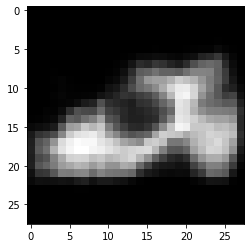

In [57]:
plt.imshow(samples[24][5].reshape((28, 28)), cmap='Greys_r')

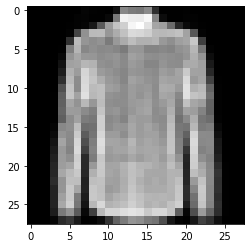

In [56]:
plt.imshow(samples[21][6].reshape((28, 28)), cmap='Greys_r')

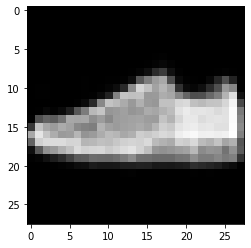

In [51]:
plt.imshow(samples[24][7].reshape((28, 28)), cmap='Greys_r')

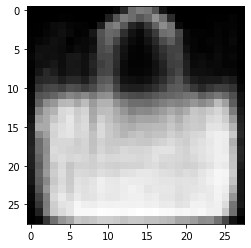

In [54]:
plt.imshow(samples[22][8].reshape((28, 28)), cmap='Greys_r')

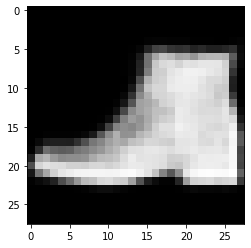

In [53]:
plt.imshow(samples[24][9].reshape((28, 28)), cmap='Greys_r')